In [1]:
from fundamental_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from photutils import CircularAperture
from photutils import aperture_photometry
import numpy as np

In [2]:
# Loading data
cube = 'J0140-0839_DATACUBE.fits'
hdu = F.open(cube)
data = hdu[1].data

In [3]:
#QSO redshift
zqso = 3.6939

#Wavelength slice (in pixels) for PSF fitting/subtraction
wave_slice=150

#Coordinate of centre of QSO (pix)
xqso = 219
yqso = 228

#Centre of the star
xqso_s = 115
yqso_s = 263

#Central wavelength for PSF fitting (ang)
lamcen_psf = 6150.0

#PSF flux scaling box size (pix)
r_psf_scale = 6

#PSF subtraction box size (pix)
#Ideally 5x seeing
r_psf_sub = 15

#Velocity search window (wrt LyA; km/s)
vmin=-11000.0
vmax=5000.0

In [4]:
nw, nx, ny = data.shape
initial_lamb = hdu[1].header['CRVAL3']

wavearr = np.arange(0.0, nw,1.0) * 1.25 + initial_lamb
ind1_lamcen_psf = int(1120 - wave_slice/2.0)
ind2_lamcen_psf = int(1120 + wave_slice/2.0)

print(wavearr[ind1_lamcen_psf], wavearr[ind2_lamcen_psf])

6056.08935546875 6243.58935546875


In [6]:
# Obtaining the spectra.

fluxes = np.zeros(len(wavearr))
circ = CircularAperture((xqso, yqso), r=10)
for i in range(len(wavearr)):
    photometry = aperture_photometry(data[i,:,:], circ)
    value = photometry['aperture_sum'].data[0]
    fluxes[i] = value

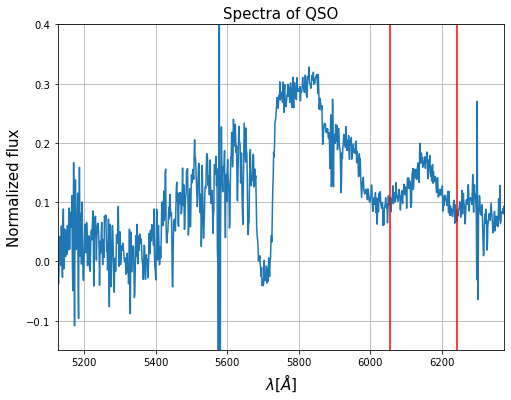

In [7]:
plt.figure(figsize=(8,6))
plt.plot(wavearr[300:1600], fluxes[300:1600]/np.max(fluxes))
plt.xlabel(r'$\lambda [{\AA}]$', fontsize=15)
plt.ylabel('Normalized flux', fontsize=15)
plt.title('Spectra of QSO', fontsize=15)
plt.grid()
plt.plot([wavearr[1045], wavearr[1045]], [-0.2, 0.4] , color='red')
plt.plot([wavearr[1195], wavearr[1195]], [-0.2, 0.4] , color='red')
plt.ylim(-0.15,0.4)
plt.xlim(wavearr[300], wavearr[1300])
plt.show()

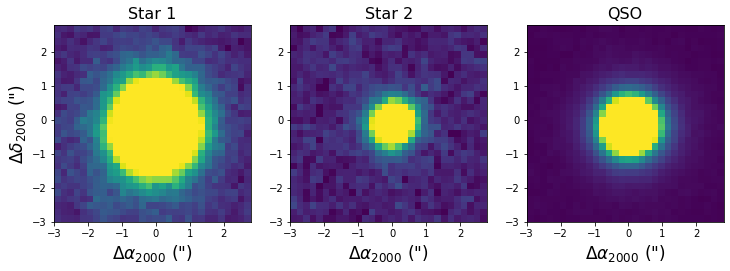

In [5]:
# Selecting the stars :D
x_s1 = 264
y_s1 = 115

x_s2 = 142
y_s2 = 191

star1_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s1-r_psf_sub):(y_s1+r_psf_sub), 
               (x_s1-r_psf_sub):(x_s1+r_psf_sub)].sum(axis=0)*1.25

star2_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s2-r_psf_sub):(y_s2+r_psf_sub), 
               (x_s2-r_psf_sub):(x_s2+r_psf_sub)].sum(axis=0)*1.25

qso_data =  data[ind1_lamcen_psf:ind2_lamcen_psf, (xqso-r_psf_sub):(xqso+r_psf_sub), 
               (yqso-r_psf_sub):(yqso+r_psf_sub)].sum(axis=0)*1.25


x = np.arange(-15,15)*0.2
y = np.arange(-15,15)*0.2

plt.figure(figsize=(12,8))

plt.subplot(131)
plt.imshow(star1_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.title('Star 1', fontsize=16)

plt.subplot(132)
plt.imshow(star2_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.title('Star 2', fontsize=16)

plt.subplot(133)
plt.imshow(qso_data, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.title('QSO', fontsize=16)

plt.show()

In [6]:
# Fitting
X, Y = np.meshgrid(x,y)
xdata = np.vstack((X.ravel(),Y.ravel()))

In [ ]:

p0 = np.array([1e5, 0. , 0., 1.0, 0.1, 1., 0. ])

param2, cov2 = curve_fit(moffat_integrated_func, xdata, star1_off.ravel(), p0=p0)
print('Terminó el 1er fit :D')

param3, cov3 = curve_fit(moffat_integrated_func, xdata, star2_off.ravel(), p0=p0)
print('Terminó el 2do fit :D')

param_QSO, cov_qso = curve_fit(moffat_integrated_func, xdata, qso_data.ravel(), p0=p0)

In [7]:
# Performing the fitting with the double component moffat PSF.
#A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set
p0_double = np.array([1e5, 1e5, 0. , 0., 1., 1., 1., 1., 0.1, 0.1, 0. ])

param2, cov2 = curve_fit(double_moffat_integrated_func, xdata, star1_off.ravel(), p0=p0_double)
print('Terminó el 1er fit :D')

param3, cov3 = curve_fit(double_moffat_integrated_func, xdata, star2_off.ravel(), p0=p0_double)
print('Terminó el 2do fit :D')

param_QSO, cov_qso = curve_fit(double_moffat_integrated_func, xdata, qso_data.ravel(), p0=p0_double)
print('Terminó el fitteo')

Terminó el 1er fit :D
Terminó el 2do fit :D
Terminó el fitteo


In [8]:
# Previously found parameters for non-double component.
param_QSO = [3.47869862e+06, -1.71284254e-01,  4.41638509e-02,  6.22461945e-01, 6.37432751e-01,  2.46842067e+00, 0.]
param_s1 = [4.18015919e+05, -2.00971753e-01, -3.07417916e-02, 7.12868901e-01, 6.84983802e-01,  1.71820283e+00, 0.]
param_s2 = [1.27500953e+05, -1.05340877e-01,  2.80799057e-02,  7.02055533e-01, 6.92711494e-01,  2.71339234e+00, 0.]

In [10]:
# Creating the PSF with the parameters
A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1 = param_QSO
A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set2 = param_s1
A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set3 = param_s2

psf_s1 = moffat_integrated_func(xdata, A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)
psf_s2 = moffat_integrated_func(xdata, A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set2, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)
psf_s3 = moffat_integrated_func(xdata, A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set3, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s1 = psf_s1.reshape(30,30)
psf_s2 = psf_s2.reshape(30,30)
psf_s3 = psf_s3.reshape(30,30)

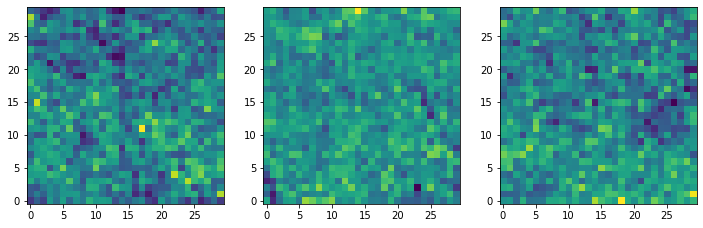

In [16]:
# Measurement of RMS sky noise near every star
sky1 = data[598:898, (xqso-r_psf_sub-50):(xqso+r_psf_sub-50), 
                (yqso-r_psf_sub):(yqso+r_psf_sub)].sum(axis=0)*1.25   # QSO sky!

sky2 = data[598:898, (y_s1-r_psf_sub-20):(y_s1+r_psf_sub-20), 
                (x_s1-r_psf_sub+40):(x_s1+r_psf_sub+40)].sum(axis=0)*1.25         # star 1 sky

sky3 = data[598:898, (y_s2-r_psf_sub-50):(y_s2+r_psf_sub-50), 
                (x_s2-r_psf_sub):(x_s2+r_psf_sub)].sum(axis=0)*1.25         # star 2 sky

 
RMS1 = np.sqrt(np.mean(sky1**2))
RMS2 = np.sqrt(np.mean(sky2**2))
RMS3 = np.sqrt(np.mean(sky3**2))


plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(sky1, origin='lower')
plt.subplot(132)
plt.imshow(sky2, origin='lower')
plt.subplot(133)
plt.imshow(sky3, origin='lower')
plt.show()

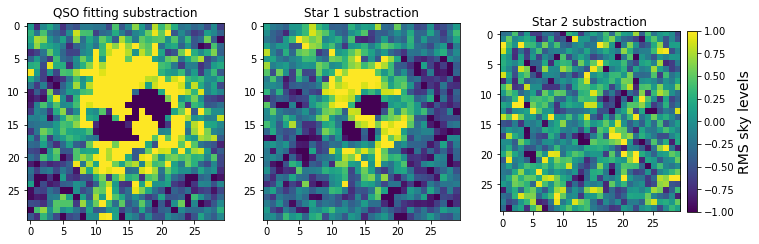

In [12]:
# Checking the fitting
diff_qso = qso_data - psf_s1
diff_s1 = star1_off - psf_s2
diff_s2 = star2_off - psf_s3

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(diff_qso/RMS1)
plt.title('QSO fitting substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s1/RMS2)
plt.title('Star 1 substraction')
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_s2/RMS3)
plt.title('Star 2 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)


In [9]:
# Getting the centers of each PSF
psfcen_1 = np.argwhere(psf_s1 == np.max(psf_s1))[0]
psfcen_2 = np.argwhere(psf_s2 == np.max(psf_s2))[0]
psfcen_3 = np.argwhere(psf_s3 == np.max(psf_s3))[0]

#Get wavelenth of LyA at QSO redshift
wLyA = 1215.6701 * (1.0+zqso) 
#Create a search windown using minimum/maximm velocities; convert to wavelength
wmin = (1+vmin/2.998e5)*wLyA
wmax = (1+vmax/2.998e5)*wLyA

#Get indicies of this serach windown
windmin = 598
windmax = 598+243

#Get indicies in steps of wavelength slice
winds = np.arange(windmin, windmax, wave_slice)

print(wmin, wmax)

5496.865727932729 5801.401225325124


In [10]:
sub_img1, img_1, norm1 = flux_scaling(psf_s1, xqso, yqso, psfcen_1, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img2, img_2, norm2 = flux_scaling(psf_s2, y_s1, x_s1, psfcen_2, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3, img_3, norm3 = flux_scaling(psf_s3, y_s2, x_s2, psfcen_3, winds, wave_slice, data, r_psf_sub, r_psf_scale)

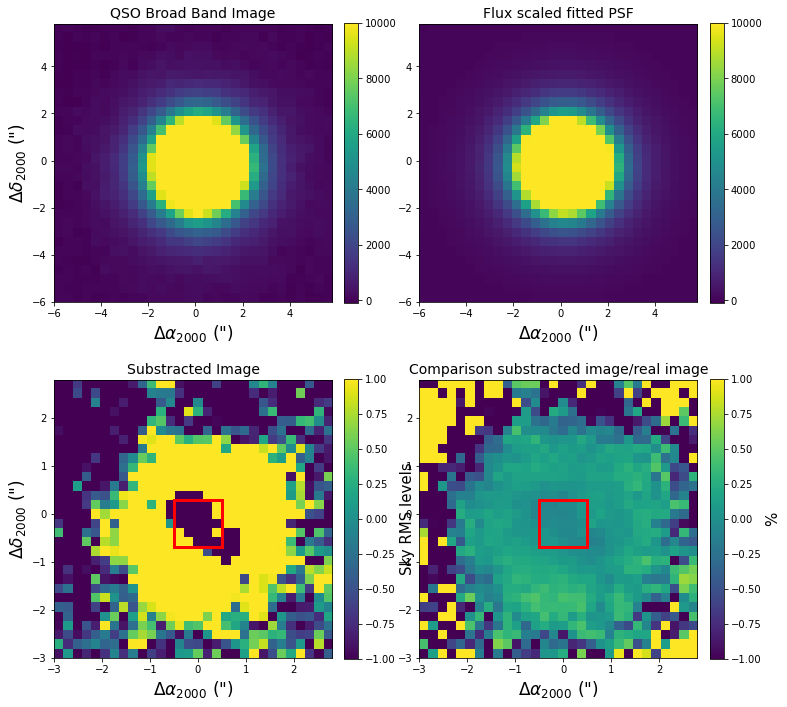

In [13]:
x2 = np.arange(-30,30)*0.2
y2 = np.arange(-30,30)*0.2

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_1, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,10000)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s1*norm1, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1/RMS1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1/img_1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

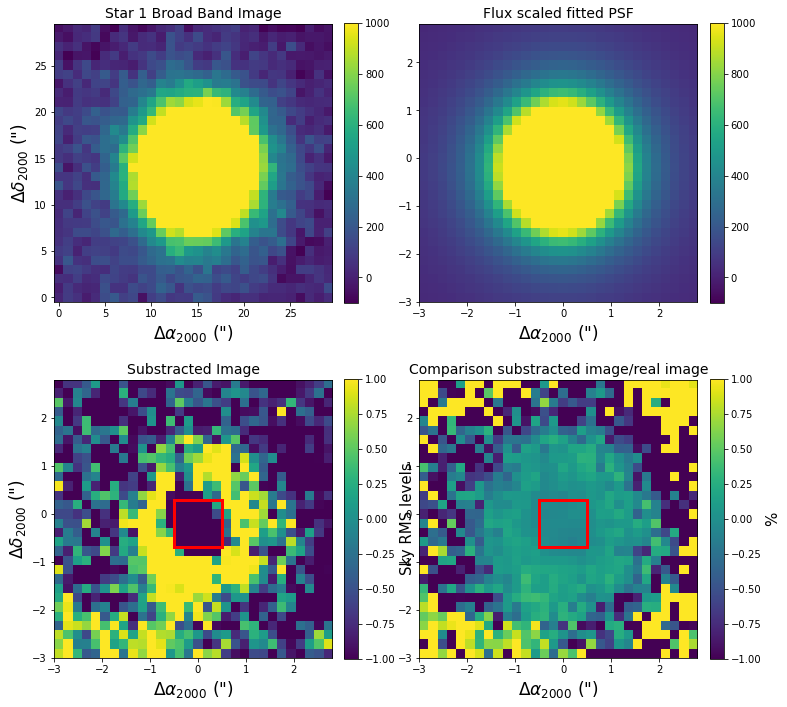

In [14]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_2, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 1 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s2*norm2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax= plt.subplot(223)
plt.imshow(sub_img2/RMS2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)


ax=plt.subplot(224)
plt.imshow(sub_img2/img_2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)
plt.show()

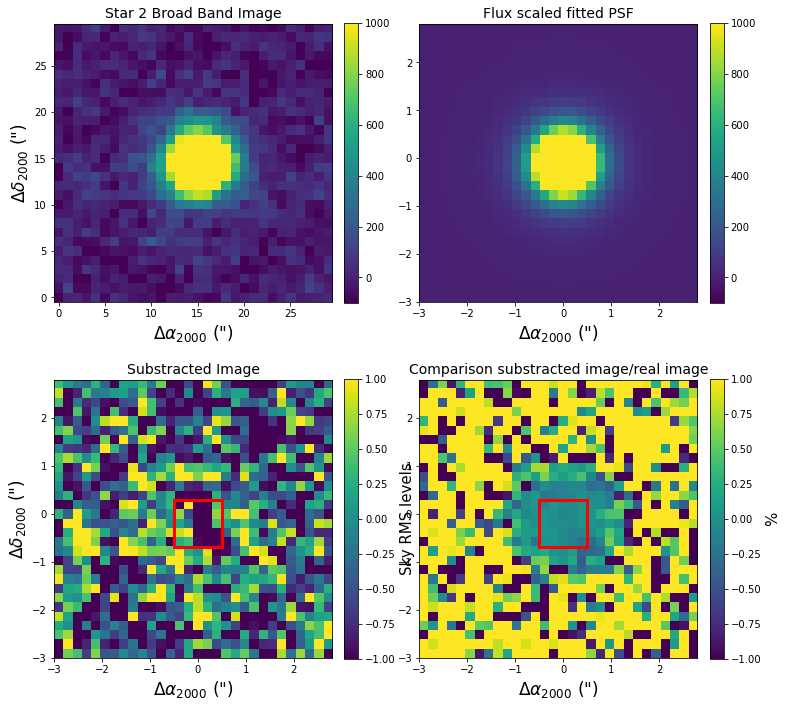

In [15]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_3, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 2 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s3*norm3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax2 = plt.subplot(223)
plt.imshow(sub_img3/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)

ax=plt.subplot(224)
plt.imshow(sub_img3/img_3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)
plt.show()

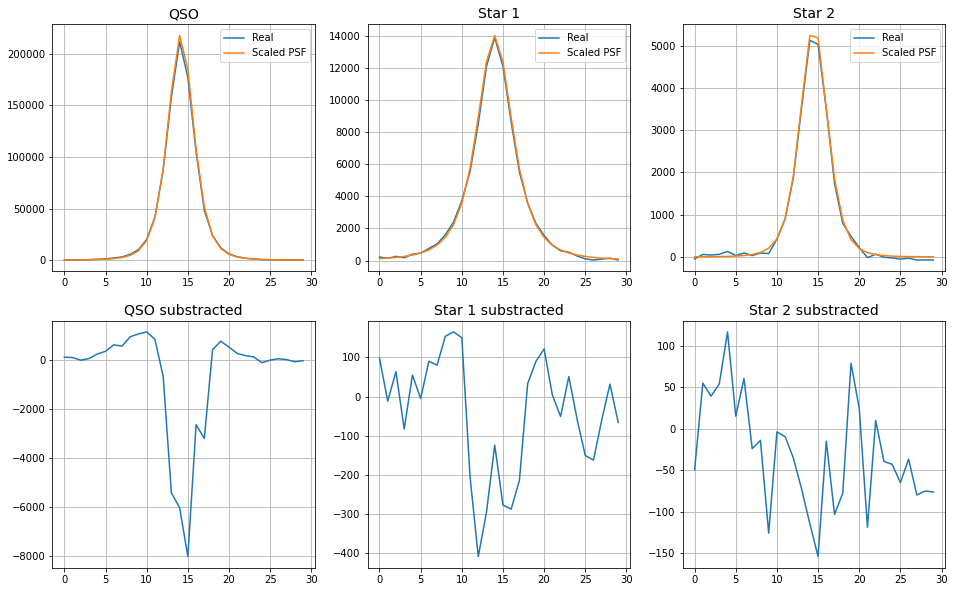

In [21]:
# Looking how is the method working in some horizontal slices

corte_img1 = img_1[:,15]
corte_psf1 = psf_s1[:,15]

corte_img2 = img_2[:,15]
corte_psf2 = psf_s2[:,15]

corte_img3 = img_3[:,15]
corte_psf3 = psf_s3[:,15]

plt.figure(figsize=(16,10))
plt.subplot(231)
plt.plot(corte_img1, label='Real')
plt.plot(corte_psf1*norm1, label='Scaled PSF')
plt.title('QSO', fontsize=14)
plt.grid()
plt.legend()

plt.subplot(232)
plt.plot(corte_img2, label='Real')
plt.plot(corte_psf2*norm2, label='Scaled PSF')
plt.title('Star 1', fontsize=14)
plt.grid()
plt.legend()

plt.subplot(233)
plt.plot(corte_img3, label='Real')
plt.plot(corte_psf3*norm3, label='Scaled PSF')
plt.title('Star 2', fontsize=14)
plt.grid()
plt.legend()

plt.subplot(234)
plt.plot(corte_img1-corte_psf1*norm1)
plt.title('QSO substracted', fontsize=14)
plt.grid()

plt.subplot(235)
plt.plot(corte_img2-corte_psf2*norm2)
plt.title('Star 1 substracted', fontsize=14)
plt.grid()

plt.subplot(236)
plt.plot(corte_img3-corte_psf3*norm3)
plt.title('Star 2 substracted', fontsize=14)
plt.grid()
plt.show()


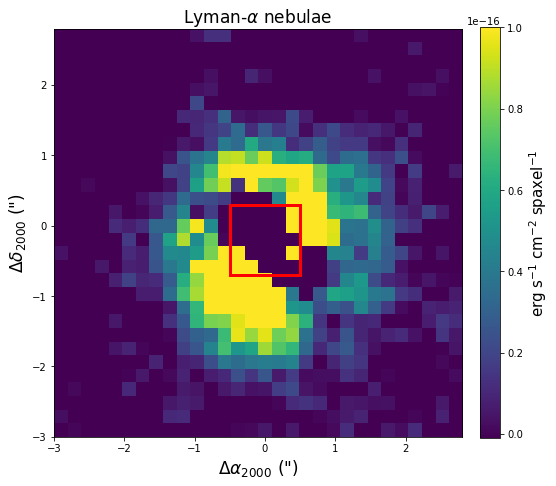

In [42]:
# Final nebula
scaling_factor = 10e-20

plt.figure(figsize=(8,8))

ax3 =plt.subplot(111)
plt.imshow(sub_img1*scaling_factor, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-10*scaling_factor,1000*scaling_factor)
cb.set_label(r'erg s$^{-1}$ cm$^{-2}$ spaxel$^{-1}$', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title(r'Lyman-$\alpha$ nebulae', fontsize=17)

plt.show()